# Few-shot candidate selection (LLM-as-judge)

This notebook loads:
- `data/kadaster_non_empty_results.json` (SELECT queries with non-empty bindings; compacted)
- `data/kadaster_rdf_results.json` (CONSTRUCT/DESCRIBE-like Turtle samples; compacted)

It then scores each candidate across multiple dimensions and selects **Top-K** few-shot examples for an MCP tool context.

The judge uses OpenAI via `OPENAI_API_KEY` (read from `.env` if present).


## Setup

Generate compacted datasets first:

```bash
python3 scripts/collect_non_empty.py
python3 scripts/collect_rdf.py
```

Optional env:
- `OPENAI_API_KEY`
- `OPENAI_MODEL` (default: `gpt-5.2`)
- `FEWSHOT_TOP_K` (default: `10`)


In [1]:
from __future__ import annotations

import hashlib
import json
import os
import re
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Optional

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv("../.env")  # loads OPENAI_API_KEY if present

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

TOP_K = int(os.getenv("FEWSHOT_TOP_K", "10"))
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-5.2")

TOP_K, OPENAI_MODEL

(10, 'gpt-5.2')

In [2]:
NON_EMPTY_PATH = Path("../data/kadaster_non_empty_results.json")
RDF_PATH = Path("../data/kadaster_rdf_results.json")

assert NON_EMPTY_PATH.exists(), f"Missing {NON_EMPTY_PATH}"
assert RDF_PATH.exists(), f"Missing {RDF_PATH}"

non_empty = json.loads(NON_EMPTY_PATH.read_text(encoding="utf-8"))
rdf = json.loads(RDF_PATH.read_text(encoding="utf-8"))

len(non_empty.get("items", {})), len(rdf.get("items", {}))

(41, 24)

## Build candidates

We create a normalized candidate record for each query.

Dimensions we will score:
- **NL quality**: clear user-facing description/question
- **SPARQL quality**: readable, idiomatic, stable, not overly brittle
- **Result usefulness**: returns meaningful, non-trivial results
- **Few-shot value**: likely to generalize patterns to other questions
- **Safety / cost**: avoids huge scans, missing LIMIT, overly broad patterns
- **Visualization value**: geometry/graph outputs that benefit from Kadaster UI


In [3]:
QUERY_TYPE_RE = re.compile(r"\b(select|construct|ask|describe)\b", re.IGNORECASE)


def infer_query_type(q: Any) -> str | None:
    if not isinstance(q, str) or not q.strip():
        return None
    m = QUERY_TYPE_RE.search(q)
    return m.group(1).upper() if m else None


def has_limit(q: Any) -> bool:
    if not isinstance(q, str):
        return False
    return bool(re.search(r"\blimit\s+\d+\b", q, re.IGNORECASE))


def has_service(q: Any) -> bool:
    if not isinstance(q, str):
        return False
    return " service " in f" {q.lower()} "


def contains_geometry(q: Any) -> bool:
    if not isinstance(q, str):
        return False
    low = q.lower()
    return any(tok in low for tok in ["geosparql", "aswkt", "geo:", "bif:st_", "st_intersects"])  


@dataclass
class Candidate:
    id: str
    name: str | None
    owner: str | None
    visualization: Any
    dataset_name: str | None
    nl: str | None
    sparql: str | None
    query_type: str | None
    has_limit: bool
    has_service: bool
    has_geometry: bool
    kind: str  # 'select' or 'rdf'
    exec_compact: dict[str, Any]


def to_candidate(obj: dict[str, Any], kind: str) -> Candidate:
    meta = obj.get("meta") if isinstance(obj.get("meta"), dict) else {}
    ctx = obj.get("prompt_context") if isinstance(obj.get("prompt_context"), dict) else {}
    sparql = obj.get("output_sparql")
    qt = infer_query_type(sparql)
    return Candidate(
        id=str(meta.get("id") or ""),
        name=meta.get("name") or meta.get("displayName"),
        owner=meta.get("owner"),
        visualization=meta.get("visualization"),
        dataset_name=ctx.get("dataset_name"),
        nl=obj.get("input_natural_language"),
        sparql=sparql,
        query_type=qt,
        has_limit=has_limit(sparql),
        has_service=has_service(sparql),
        has_geometry=contains_geometry(sparql) or (isinstance(meta.get("visualization"), str) and "map" in meta.get("visualization").lower()),
        kind=kind,
        exec_compact=obj.get("execution_result_sample") if isinstance(obj.get("execution_result_sample"), dict) else {},
    )


candidates: list[Candidate] = []
for _id, obj in non_empty.get("items", {}).items():
    candidates.append(to_candidate(obj, kind="select"))
for _id, obj in rdf.get("items", {}).items():
    candidates.append(to_candidate(obj, kind="rdf"))

len(candidates), sum(1 for c in candidates if c.kind == "select"), sum(1 for c in candidates if c.kind == "rdf")

(65, 41, 24)

## Heuristic scoring (cheap)

Before paying for LLM calls, we compute a heuristic score to prioritize good candidates.

This helps:
- Filter obvious low-quality examples (missing NL, no LIMIT, too short/too long)
- Prioritize diverse, result-rich examples for LLM judging


In [4]:
def heuristic_score(c: Candidate) -> dict[str, Any]:
    nl = c.nl or ""
    sparql = c.sparql or ""

    s = 0.0
    reasons = []

    if len(nl.strip()) >= 20:
        s += 10
    else:
        s -= 20
        reasons.append("nl_too_short")

    if len(sparql.strip()) >= 50:
        s += 5
    else:
        s -= 10
        reasons.append("sparql_too_short")

    if c.has_limit:
        s += 10
    else:
        s -= 10
        reasons.append("missing_limit")

    if c.has_service:
        s += 2

    if c.has_geometry:
        s += 5

    # Result richness
    if c.kind == "select":
        r = c.exec_compact.get("results", {})
        bindings_count = r.get("bindings_count")
        if isinstance(bindings_count, int):
            if bindings_count >= 10:
                s += 15
            elif bindings_count >= 3:
                s += 10
            else:
                s += 5
        else:
            s -= 5
            reasons.append("unknown_bindings_count")
    elif c.kind == "rdf":
        # Higher density of Turtle terminators suggests a meaningful graph sample
        term = c.exec_compact.get("statement_terminators_estimate")
        if isinstance(term, int):
            if term >= 50:
                s += 15
            elif term >= 15:
                s += 10
            else:
                s += 5

    # Penalize extremely long queries (often too domain-specific / brittle)
    if len(sparql) > 6000:
        s -= 10
        reasons.append("sparql_very_long")

    return {"heuristic_score": float(s), "heuristic_flags": reasons}


heur = {c.id: heuristic_score(c) for c in candidates}
sorted_heur = sorted(((c, heur[c.id]) for c in candidates), key=lambda x: x[1]["heuristic_score"], reverse=True)
[(x[0].id, x[0].kind, x[1]["heuristic_score"], x[1]["heuristic_flags"]) for x in sorted_heur[:10]]

[('64943731ad338c079e6305ce', 'select', 17.0, ['nl_too_short']),
 ('64943ca6ad338c079e6432cb', 'select', 17.0, ['nl_too_short']),
 ('64b91906697971dc50c7a126', 'select', 17.0, ['nl_too_short']),
 ('62b8abb8513bdbee6baab229', 'select', 15.0, ['nl_too_short']),
 ('64b917fe697971dc50c78e2a', 'select', 15.0, ['nl_too_short']),
 ('6542322583ec0da0a09bc7a5', 'select', 15.0, ['missing_limit']),
 ('67234d45810ffc0ccee62ce6', 'select', 15.0, ['nl_too_short']),
 ('67234d75810ffc0ccee89fdb', 'select', 15.0, ['nl_too_short']),
 ('67234da10dcaf35f1367f202', 'select', 15.0, ['nl_too_short']),
 ('67234e320dcaf35f136bd51c', 'select', 15.0, ['nl_too_short'])]

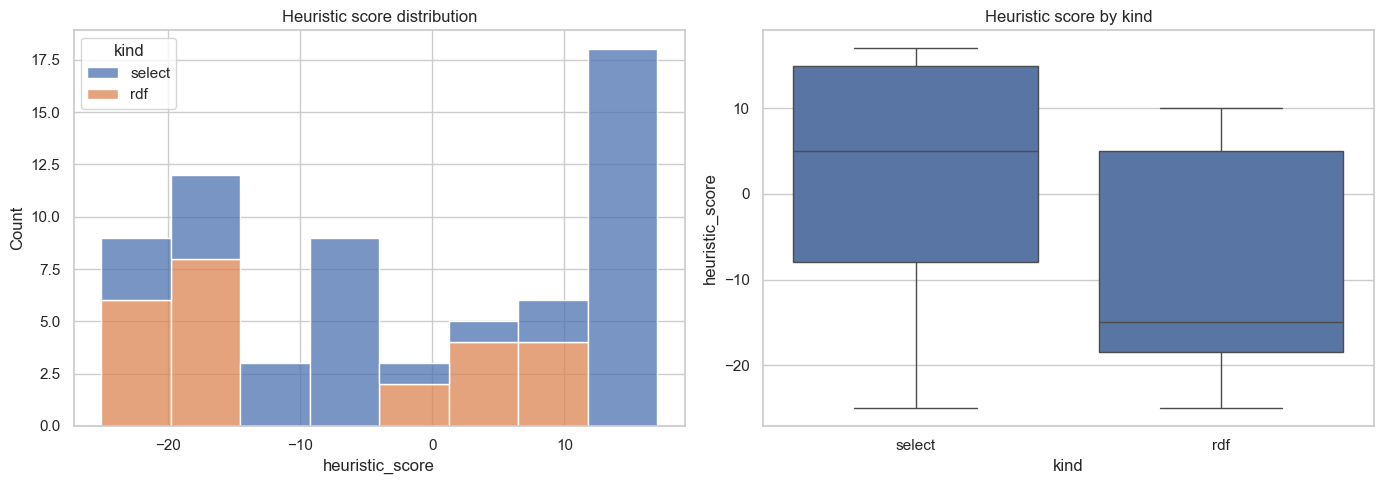

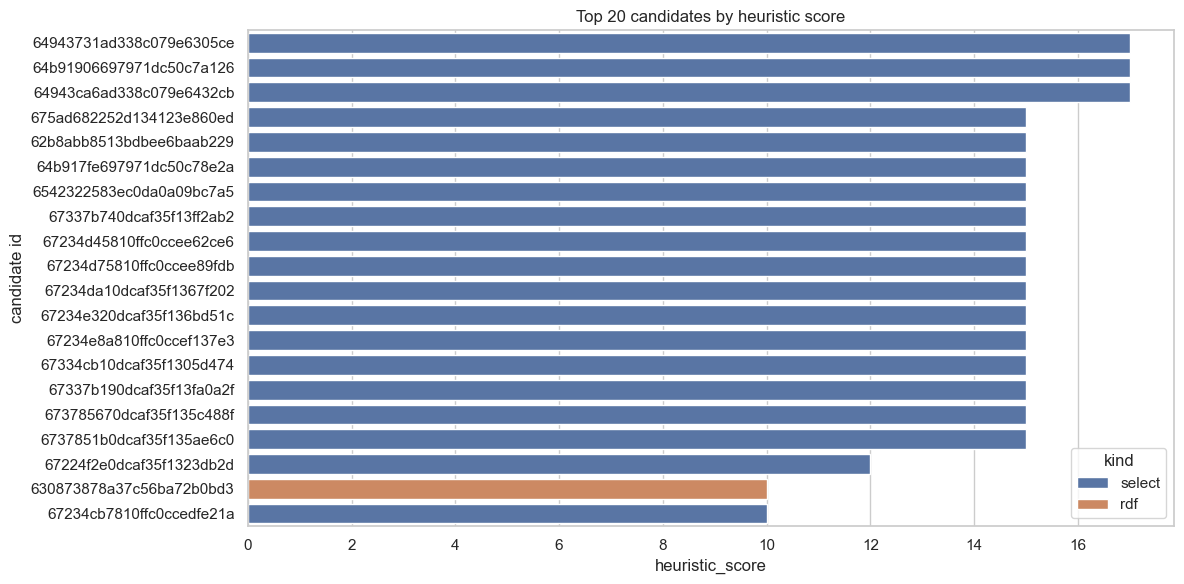

In [5]:
# Heuristic score visualizations
df_heur = pd.DataFrame(
    [
        {
            "id": c.id,
            "kind": c.kind,
            "query_type": c.query_type,
            "has_limit": c.has_limit,
            "has_service": c.has_service,
            "has_geometry": c.has_geometry,
            "sparql_len": len(c.sparql or ""),
            "nl_len": len((c.nl or "").strip()),
            "heuristic_score": heur[c.id]["heuristic_score"],
        }
        for c in candidates
    ]
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=df_heur, x="heuristic_score", hue="kind", multiple="stack", ax=axes[0])
axes[0].set_title("Heuristic score distribution")

sns.boxplot(data=df_heur, x="kind", y="heuristic_score", ax=axes[1])
axes[1].set_title("Heuristic score by kind")
plt.tight_layout()
plt.show()

top_h = df_heur.sort_values("heuristic_score", ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_h, x="heuristic_score", y="id", hue="kind", dodge=False)
plt.title("Top 20 candidates by heuristic score")
plt.xlabel("heuristic_score")
plt.ylabel("candidate id")
plt.tight_layout()
plt.show()

## LLM judge

The judge returns a strict JSON object with per-dimension ratings and an overall score.

We cache results in `notebooks/judge_cache.jsonl` to avoid repeated spend.


In [ ]:
from openai import OpenAI

client = OpenAI()

CACHE_PATH = Path("notebooks/judge_cache.jsonl")
CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)


def stable_id(c: Candidate) -> str:
    # hash of NL+SPARQL to make caching robust to file/key changes
    h = hashlib.sha256()
    h.update((c.nl or "").encode("utf-8"))
    h.update(b"\n---\n")
    h.update((c.sparql or "").encode("utf-8"))
    return h.hexdigest()


def load_cache() -> dict[str, Any]:
    cache: dict[str, Any] = {}
    if not CACHE_PATH.exists():
        return cache
    for line in CACHE_PATH.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except Exception:
            continue
        cid = obj.get("candidate_hash")
        if isinstance(cid, str):
            cache[cid] = obj
    return cache


cache = load_cache()
len(cache)

In [7]:
JUDGE_SYSTEM = """You are an expert data engineer judging whether a (natural language question, SPARQL, result sample) pair is a good few-shot example for an agent that generates SPARQL for the Kadaster KKG endpoint.

Return ONLY valid JSON (no markdown)."""


def build_candidate_payload(c: Candidate) -> dict[str, Any]:
    # Keep prompt small but informative.
    payload: dict[str, Any] = {
        "id": c.id,
        "kind": c.kind,
        "name": c.name,
        "owner": c.owner,
        "dataset_name": c.dataset_name,
        "visualization": c.visualization,
        "natural_language": (c.nl or "").strip(),
        "sparql": (c.sparql or "").strip(),
        "query_type": c.query_type,
        "has_limit": c.has_limit,
        "has_service": c.has_service,
        "has_geometry": c.has_geometry,
    }

    if c.kind == "select":
        results = c.exec_compact.get("results", {})
        payload["result"] = {
            "format": "sparql-json",
            "bindings_count": results.get("bindings_count"),
            "bindings_sample": results.get("bindings"),
            "vars": (c.exec_compact.get("head") or {}).get("vars"),
        }
    else:
        payload["result"] = {
            "format": "turtle",
            "content_type": c.exec_compact.get("content_type"),
            "text_sample": c.exec_compact.get("text_sample"),
            "statement_terminators_estimate": c.exec_compact.get("statement_terminators_estimate"),
        }

    return payload


JUDGE_PROMPT = """Evaluate this candidate as a few-shot example for SPARQL generation.

Score each dimension from 0 to 5 (integer):
- nl_quality: Is the natural language question clear and user-like?
- sparql_quality: Is the SPARQL readable/idiomatic and likely correct?
- result_usefulness: Are results meaningful and not trivial/empty?
- fewshot_generalization: Does it demonstrate reusable patterns?
- safety_cost: Is it safe/cost-aware (LIMIT, not overly broad)?
- visualization_value: Would the Kadaster UI/geometry visualization add value for debugging or interpretation?

Then compute overall_score_0_100 (integer) with your own weighting.

Also return:
- tags: array of short strings
- issues: array of short strings (empty if none)
- short_rationale: 1-3 sentences

Return JSON with this exact schema:
{
  "nl_quality": int,
  "sparql_quality": int,
  "result_usefulness": int,
  "fewshot_generalization": int,
  "safety_cost": int,
  "visualization_value": int,
  "overall_score_0_100": int,
  "tags": [string],
  "issues": [string],
  "short_rationale": string
}
"""


In [8]:
def judge_one(c: Candidate, *, max_retries: int = 3, sleep_s: float = 1.5) -> dict[str, Any]:
    cand_hash = stable_id(c)
    if cand_hash in cache:
        return cache[cand_hash]

    payload = build_candidate_payload(c)
    messages = [
        {"role": "system", "content": JUDGE_SYSTEM},
        {"role": "user", "content": JUDGE_PROMPT + "\n\nCANDIDATE:\n" + json.dumps(payload, ensure_ascii=False)},
    ]

    last_err: Optional[Exception] = None
    for attempt in range(1, max_retries + 1):
        try:
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=messages,
                temperature=0,
                response_format={"type": "json_object"},
            )
            content = resp.choices[0].message.content
            judged = json.loads(content)
            record = {
                "candidate_id": c.id,
                "candidate_hash": cand_hash,
                "kind": c.kind,
                "model": OPENAI_MODEL,
                "judgement": judged,
            }
            CACHE_PATH.write_text(
                (CACHE_PATH.read_text(encoding="utf-8") if CACHE_PATH.exists() else "")
                + json.dumps(record, ensure_ascii=False)
                + "\n",
                encoding="utf-8",
            )
            cache[cand_hash] = record
            return record
        except Exception as e:
            last_err = e
            time.sleep(sleep_s * attempt)

    raise last_err


### Run judging (cost control)

To limit spend, judge only the top-N heuristic candidates first.


In [9]:
N_TO_JUDGE = 40  # adjust

to_judge = [c for (c, _h) in sorted_heur[:N_TO_JUDGE]]
len(to_judge), to_judge[0].id, to_judge[0].kind

(40, '64943731ad338c079e6305ce', 'select')

In [10]:
# Run sequentially to keep it simple/reliable.
# If you want parallelization, do it carefully to avoid rate-limit bursts.

judged_records = []
for i, c in enumerate(to_judge, start=1):
    rec = judge_one(c)
    judged_records.append(rec)
    if i % 5 == 0:
        print(f"judged {i}/{len(to_judge)}")

len(judged_records)

judged 5/40
judged 10/40
judged 15/40
judged 20/40
judged 25/40
judged 30/40
judged 35/40
judged 40/40


40

## Compute final score and select Top-K

We combine:
- LLM `overall_score_0_100`
- Heuristic score (scaled)

Final score = `0.7 * llm + 0.3 * heuristic_scaled`.


In [11]:
def heuristic_to_0_100(h: float) -> float:
    # Typical heuristic range ~[-40, 45]. Clamp then scale.
    h = max(-50.0, min(50.0, h))
    return (h + 50.0)  # 0..100


def get_candidate_by_id(cid: str) -> Candidate:
    for c in candidates:
        if c.id == cid:
            return c
    raise KeyError(cid)


rows = []
for rec in judged_records:
    c = get_candidate_by_id(rec["candidate_id"])
    j = rec["judgement"]
    h = heur[c.id]["heuristic_score"]
    llm = float(j.get("overall_score_0_100", 0))
    h100 = heuristic_to_0_100(float(h))
    final = 0.7 * llm + 0.3 * h100
    rows.append(
        {
            "id": c.id,
            "kind": c.kind,
            "name": c.name,
            "query_type": c.query_type,
            "has_limit": c.has_limit,
            "has_geometry": c.has_geometry,
            "llm_overall": llm,
            "heuristic": h,
            "heuristic_0_100": h100,
            "final_score": final,
            "tags": j.get("tags", []),
            "issues": j.get("issues", []),
        }
    )

rows_sorted = sorted(rows, key=lambda r: r["final_score"], reverse=True)
rows_sorted[:10]

[{'id': '64943731ad338c079e6305ce',
  'kind': 'select',
  'name': 'bouwlagen-adres-pand',
  'query_type': 'SELECT',
  'has_limit': True,
  'has_geometry': True,
  'llm_overall': 62.0,
  'heuristic': 17.0,
  'heuristic_0_100': 67.0,
  'final_score': 63.5,
  'tags': ['federated-query',
   'SERVICE',
   'address-formatting',
   'bag-imxgeo',
   'prediction-data',
   'optional-bind-concat',
   'limit'],
  'issues': ['Natural language question is empty',
   'Declares has_geometry=true but query does not select/construct geometry',
   'Some unused prefixes (skos, sor, rdf, rdfs) reduce clarity',
   'No ORDER BY; results may be non-deterministic across runs']},
 {'id': '64943ca6ad338c079e6432cb',
  'kind': 'select',
  'name': 'bouwlagen-hoogste-gebouw',
  'query_type': 'SELECT',
  'has_limit': True,
  'has_geometry': True,
  'llm_overall': 56.0,
  'heuristic': 17.0,
  'heuristic_0_100': 67.0,
  'final_score': 59.3,
  'tags': ['geo',
   'geosparql',
   'geometry',
   'federated-service',
   's

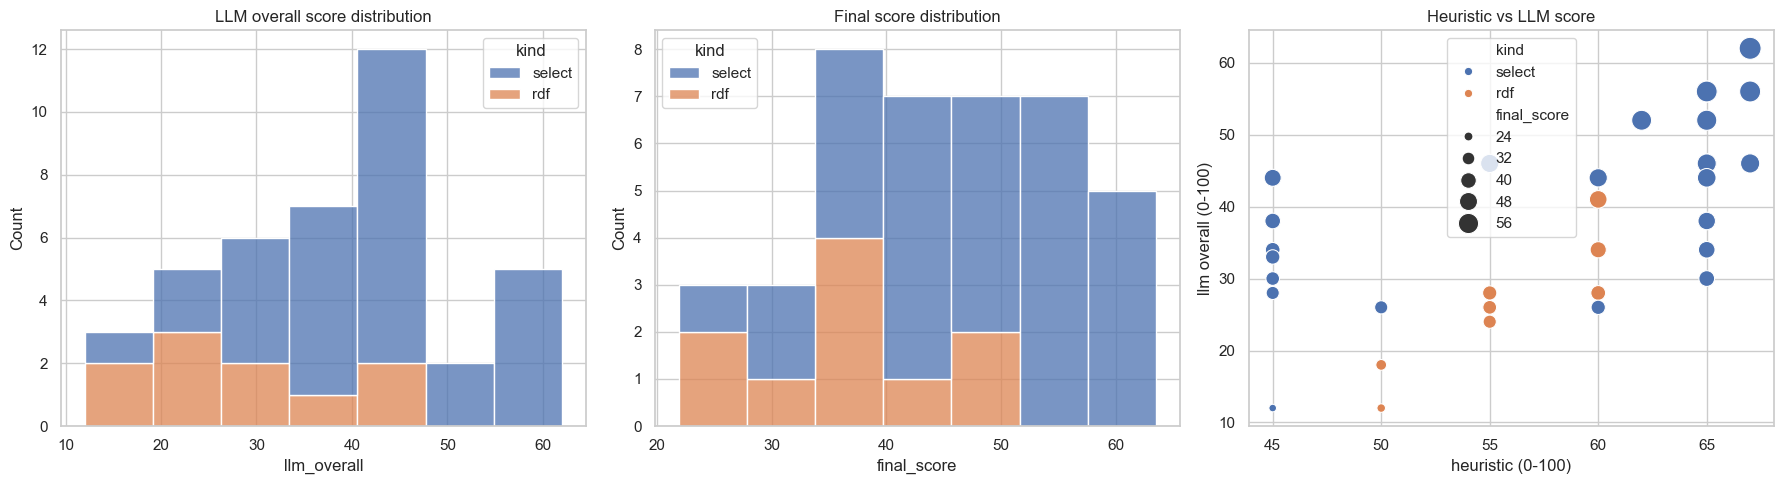

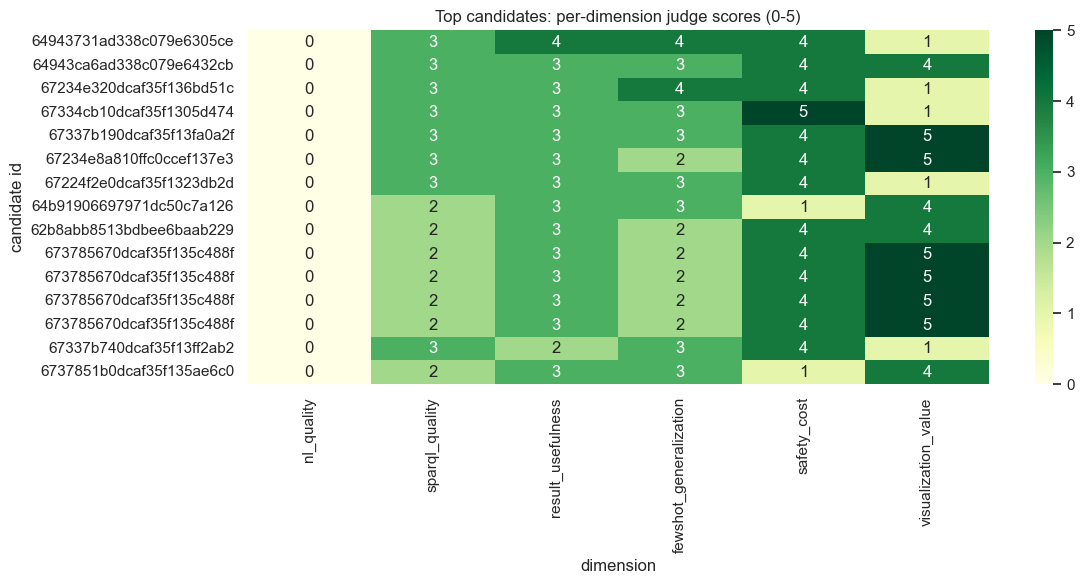

In [12]:
# Score visualizations (after judging)
df_scores = pd.DataFrame(rows_sorted)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data=df_scores, x="llm_overall", hue="kind", multiple="stack", ax=axes[0])
axes[0].set_title("LLM overall score distribution")

sns.histplot(data=df_scores, x="final_score", hue="kind", multiple="stack", ax=axes[1])
axes[1].set_title("Final score distribution")

sns.scatterplot(
    data=df_scores,
    x="heuristic_0_100",
    y="llm_overall",
    hue="kind",
    size="final_score",
    sizes=(30, 250),
    ax=axes[2],
)
axes[2].set_title("Heuristic vs LLM score")
axes[2].set_xlabel("heuristic (0-100)")
axes[2].set_ylabel("llm overall (0-100)")
plt.tight_layout()
plt.show()

# Dimension heatmap for top candidates
dims = [
    "nl_quality",
    "sparql_quality",
    "result_usefulness",
    "fewshot_generalization",
    "safety_cost",
    "visualization_value",
]

df_dims = pd.DataFrame(
    [
        {"id": rec["candidate_id"], "kind": rec.get("kind"), **(rec.get("judgement") or {})}
        for rec in judged_records
    ]
)
df_dims = df_dims.merge(df_scores[["id", "final_score"]], on="id", how="left")
df_top = df_dims.sort_values("final_score", ascending=False).head(min(15, len(df_dims)))

plt.figure(figsize=(12, 6))
sns.heatmap(
    df_top.set_index("id")[dims],
    cmap="YlGn",
    vmin=0,
    vmax=5,
    annot=True,
    fmt=".0f",
)
plt.title("Top candidates: per-dimension judge scores (0-5)")
plt.xlabel("dimension")
plt.ylabel("candidate id")
plt.tight_layout()
plt.show()

In [13]:
top_k = rows_sorted[:TOP_K]
[(r["id"], r["kind"], round(r["final_score"], 2), r["issues"]) for r in top_k]

[('64943731ad338c079e6305ce',
  'select',
  63.5,
  ['Natural language question is empty',
   'Declares has_geometry=true but query does not select/construct geometry',
   'Some unused prefixes (skos, sor, rdf, rdfs) reduce clarity',
   'No ORDER BY; results may be non-deterministic across runs']),
 ('64943ca6ad338c079e6432cb',
  'select',
  59.3,
  ['Missing natural language question',
   'Query intent unclear (no filter on place/area despite using imxgeo:plaatsnaam)',
   "Subquery LIMIT 100 may bias 'highest building' result set and make it non-global",
   'Unused prefixes (wbk, dc, skos, sor, rdfs, bag) add noise',
   'Uses OFFSET 0 redundantly']),
 ('67234e320dcaf35f136bd51c',
  'select',
  58.7,
  ['Natural language question is empty',
   'Query uses ?postcode in BIND but never binds it (should use the literal or bind it)',
   'SELECT * reduces clarity for few-shot (better to project explicit variables)',
   'Unused prefix ext:',
   'No geometry selected despite has_geometry=true;

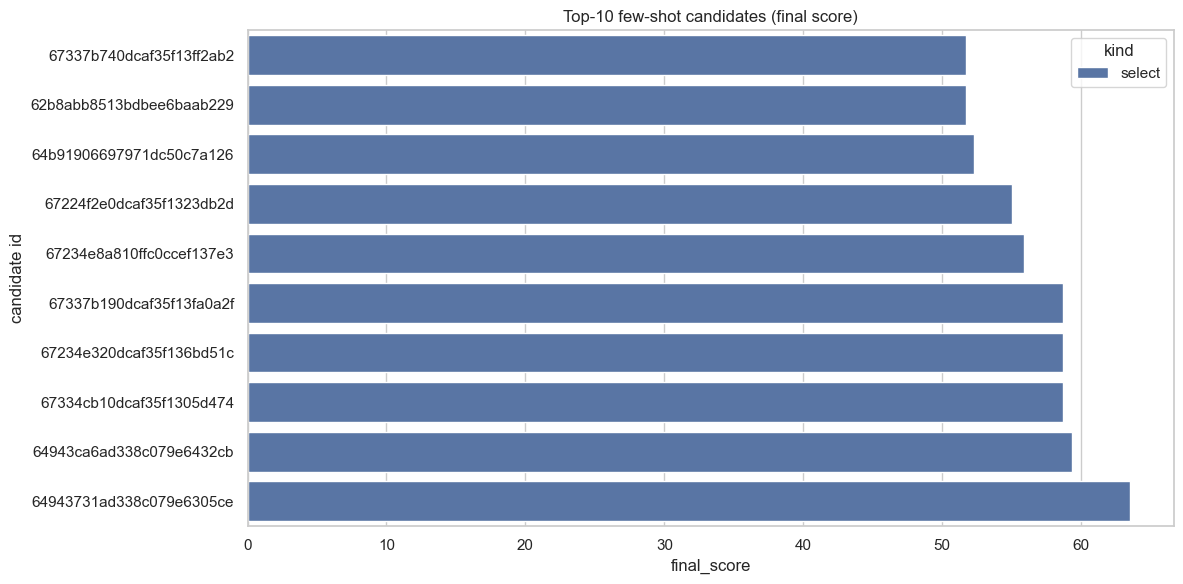

In [14]:
# Top-K bar chart
df_topk = pd.DataFrame(top_k)
df_topk = df_topk.sort_values("final_score", ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_topk, x="final_score", y="id", hue="kind", dodge=False)
plt.title(f"Top-{TOP_K} few-shot candidates (final score)")
plt.xlabel("final_score")
plt.ylabel("candidate id")
plt.tight_layout()
plt.show()

## Export Top-K few-shot pack

This writes a compact JSON file that you can feed into your MCP server as curated few-shot examples.


In [16]:
def export_item(c: Candidate) -> dict[str, Any]:
    out = {
        "id": c.id,
        "kind": c.kind,
        "name": c.name,
        "dataset_name": c.dataset_name,
        "natural_language": c.nl,
        "sparql": c.sparql,
        "query_type": c.query_type,
        "has_geometry": c.has_geometry,
        "result_sample": c.exec_compact,
    }
    return out


fewshot_items = []
for r in top_k:
    c = get_candidate_by_id(r["id"])
    cand_hash = stable_id(c)
    record = cache.get(cand_hash) or {}
    judged = record.get("judgement") if isinstance(record, dict) else None

    item = export_item(c)
    item["judge"] = judged
    item["final_score"] = r["final_score"]
    fewshot_items.append(item)

out_path = Path("../data/fewshot_topk.json")
out_path.write_text(json.dumps({"top_k": TOP_K, "items": fewshot_items}, ensure_ascii=False, indent=2), encoding="utf-8")
out_path

WindowsPath('../data/fewshot_topk.json')